In [76]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

concatenatedfile_path=os.path.join("..", "data", "processed","concatenated_data")

event=pd.read_parquet(f'{concatenatedfile_path}/event_concatenated.parquet')
away_team=pd.read_parquet(f'{concatenatedfile_path}/away_team_concatenated.parquet')
away_team_score=pd.read_parquet(f'{concatenatedfile_path}/away_team_score_concatenated.parquet')
home_team=pd.read_parquet(f'{concatenatedfile_path}/home_team_concatenated.parquet')
home_team_score=pd.read_parquet(f'{concatenatedfile_path}/home_team_score_concatenated.parquet')
odds=pd.read_parquet(f'{concatenatedfile_path}/odds_concatenated.parquet')
pbp=pd.read_parquet(f'{concatenatedfile_path}/pbp_concatenated.parquet')
power=pd.read_parquet(f'{concatenatedfile_path}/power_concatenated.parquet')
round=pd.read_parquet(f'{concatenatedfile_path}/round_concatenated.parquet')
season=pd.read_parquet(f'{concatenatedfile_path}/season_concatenated.parquet')
statistics=pd.read_parquet(f'{concatenatedfile_path}/statistics_concatenated.parquet')
time=pd.read_parquet(f'{concatenatedfile_path}/time_concatenated.parquet')
tournament=pd.read_parquet(f'{concatenatedfile_path}/tournament_concatenated.parquet')
venue=pd.read_parquet(f'{concatenatedfile_path}/venue_concatenated.parquet')
votes=pd.read_parquet(f'{concatenatedfile_path}/votes_concatenated.parquet')


1. which players from Iran have participated in tennis competitions?

In [80]:
pd.concat([home_team[home_team['country']=='Iran'][['player_id','full_name']],away_team[away_team['country']=='Iran'][['player_id','full_name']]]).drop_duplicates()

,player_id,full_name
951,206924,"Moghimi, Sina"


2. How many players have a career spanning more than 15 years?

In [23]:
# Combine home and away team data to get player info
player_data = pd.concat([home_team[['player_id', 'turned_pro']], away_team[['player_id', 'turned_pro']]]).drop_duplicates(subset=['player_id']).dropna(subset=['turned_pro'])
current_year = 2024

# Calculate the career duration for each player
player_data['career_duration'] = current_year - player_data['turned_pro'].astype(int)

# Filter players with a career duration of more than 10 years
players_over_15_years = player_data[player_data['career_duration'] > 15]
num_players_over_15_years = players_over_15_years['player_id'].nunique()

print(f"The number of players with a career spanning more than 15 years is: {num_players_over_15_years}")

The number of players with a career spanning more than 15 years is: 95


3. What is the distribution of players' weights in the dataset?

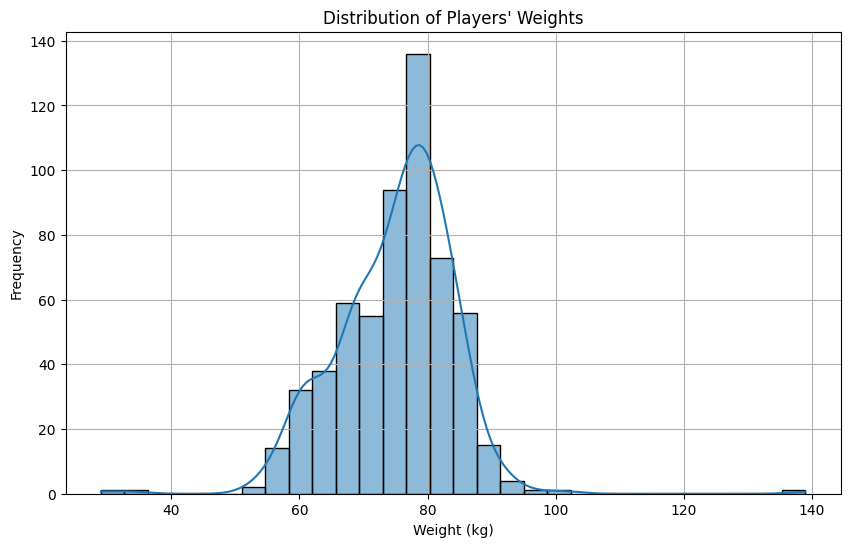

In [24]:
# Combine home and away team data to get player weights
player_weights = pd.concat([home_team[['player_id', 'weight']], away_team[['player_id', 'weight']]]).drop_duplicates(subset=['player_id']).dropna(subset=['weight'])

# Convert weights to numeric (if they are not already)
player_weights['weight'] = pd.to_numeric(player_weights['weight'], errors='coerce')

# Drop any rows that couldn't be converted to numeric
player_weights = player_weights.dropna(subset=['weight'])

# Plot the distribution of players' weights
plt.figure(figsize=(10, 6))
sns.histplot(player_weights['weight'], bins=30, kde=True)
plt.title('Distribution of Players\' Weights')
plt.xlabel('Weight (kg)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


4. Which tournament has the highest number of participating players?

In [26]:
# Combine home and away team data to get player and tournament information
home_team_tournament = home_team[['match_id', 'player_id']].merge(tournament[['match_id', 'tournament_id']], on='match_id')
away_team_tournament = away_team[['match_id', 'player_id']].merge(tournament[['match_id', 'tournament_id']], on='match_id')

# Concatenate home and away data
all_players_tournaments = pd.concat([home_team_tournament, away_team_tournament]).drop_duplicates(subset=['player_id', 'tournament_id'])

# Count the number of unique players for each tournament
tournament_player_counts = all_players_tournaments.groupby('tournament_id')['player_id'].nunique().reset_index(name='player_count')

# Find the tournament with the highest number of participating players
tournament_with_max_players = tournament_player_counts.loc[tournament_player_counts['player_count'].idxmax()]

# Get the name of the tournament
tournament_name = tournament.loc[tournament['tournament_id'] == tournament_with_max_players['tournament_id'], 'tournament_name'].values[0]
print(f"The tournament with the highest number of participating players is {tournament_name} with {tournament_with_max_players['player_count']} players.")


The tournament with the highest number of participating players is French Open, Paris, France with 130 players.


5. How many matches have been decided by a tie-break?

In [55]:
match_scores=pd.concat([home_team_score.drop_duplicates(subset=['match_id']),away_team_score.drop_duplicates(subset=['match_id'])])

# Check if there is a tie-break in any of the periods
match_scores['tie_break'] = match_scores[['period_1_tie_break', 'period_2_tie_break', 'period_3_tie_break', 'period_4_tie_break', 'period_5_tie_break']].sum(axis=1) > 0

# Count the number of matches decided by a tie-break
matches_with_tie_break = match_scores[match_scores['tie_break']].drop_duplicates(['match_id']).shape[0]
print(f"The number of matches decided by a tie-break is: {matches_with_tie_break}")


The number of matches decided by a tie-break is: 1332


6. What is the average number of games per match?

The average number of games per match is: 10.29


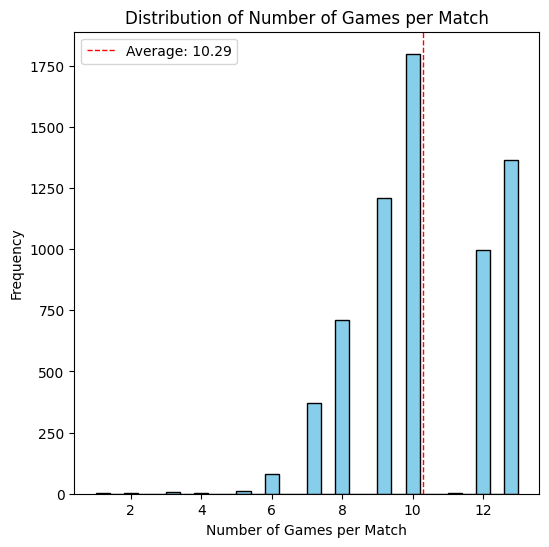

In [111]:
# Calculate the number of games in each match
games_per_match = pbp.groupby('match_id')['game_id'].nunique().reset_index(name='game_count')

# Calculate the average number of games per match
average_games_per_match = games_per_match['game_count'].mean()

print(f"The average number of games per match is: {average_games_per_match:.2f}")

# Plotting the histogram
plt.figure(figsize=(6, 6))
plt.hist(games_per_match['game_count'], bins=30, color='skyblue', edgecolor='black')
plt.axvline(average_games_per_match, color='red', linestyle='dashed', linewidth=1, label=f'Average: {average_games_per_match:.2f}')
plt.xlabel('Number of Games per Match')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Games per Match')
plt.legend()
plt.show()

7. Which player has the most double faults in a single match?

In [73]:
# Filter for double faults data
double_faults_data = statistics[(statistics['period'] == 'ALL') & (statistics['statistic_name'] == 'double_faults')]

# Merge double faults data with home and away team player information
home_double_faults = double_faults_data[['match_id', 'home_stat']].merge(home_team[['match_id', 'player_id', 'name']], on='match_id')
away_double_faults = double_faults_data[['match_id', 'away_stat']].merge(away_team[['match_id', 'player_id', 'name']], on='match_id')

# Rename columns for clarity
home_double_faults.rename(columns={'home_stat': 'double_faults'}, inplace=True)
away_double_faults.rename(columns={'away_stat': 'double_faults'}, inplace=True)

# Combine home and away double faults data
all_double_faults = pd.concat([home_double_faults[['match_id', 'player_id', 'name', 'double_faults']], 
                               away_double_faults[['match_id', 'player_id', 'name', 'double_faults']]])

# Find the player with the most double faults in a single match
max_double_faults = all_double_faults.loc[all_double_faults['double_faults'].idxmax()]
max_double_faults
print(f"The player with the most double faults in a single match is {max_double_faults['name']}")
    #    (ID: {max_double_faults['player_id']}) with {max_double_faults['double_faults']} double faults in match ID {max_double_faults['match_id']}.")

The player with the most double faults in a single match is 108         Puttergill C.
108    Rinaldo Persson K.
Name: name, dtype: object


In [70]:
all_double_faults

,match_id,player_id,name,double_faults
0,12344252,276774,Matsuda R.,2
1,12344252,276774,Matsuda R.,2
2,12346208,111837,Harris B.,2
3,12346208,111837,Harris B.,2
4,12344313,111609,Barroso Campos A.,0
...,...,...,...,...
24387,12373194,44236,Di Sarra F.,3
24388,12372904,390231,Tanasie L.,4
24389,12372904,390231,Tanasie L.,4
24390,12374417,385592,Butvilas E.,1


8. Which cities have hosted the most tennis matches?

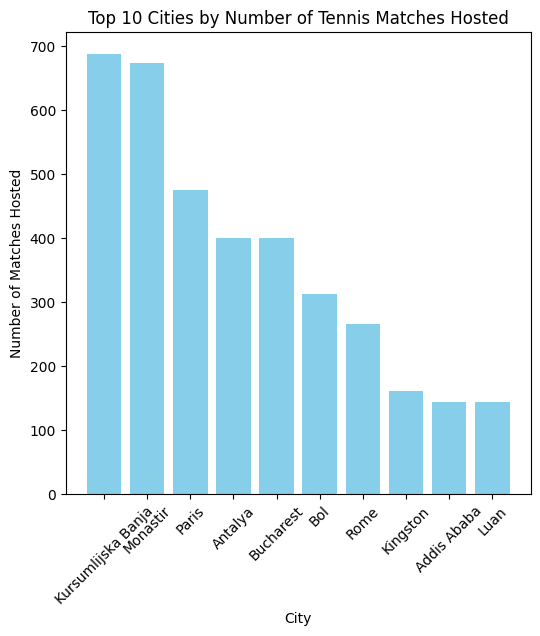

In [112]:
# Extract venue for competitions
venue_city = venue[['match_id', 'city']].drop_duplicates()

# Count the occurrences of each unique city
city_count = venue_city['city'].value_counts().reset_index()
city_count.columns = ['city', 'count']

# Display the top 10 cities that have hosted the most tennis matches
top_10_cities = city_count.head(10)
top_10_cities


# Plotting the bar chart
plt.figure(figsize=(6, 6))
plt.bar(top_10_cities['city'], top_10_cities['count'], color='skyblue')
plt.xlabel('City')
plt.ylabel('Number of Matches Hosted')
plt.title('Top 10 Cities by Number of Tennis Matches Hosted')
plt.xticks(rotation=45)
plt.show()